Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

from data.stathinpy import draw_bs_reps_ind, draw_perm_reps

pd.set_option('display.max_columns', 100)
sns.set()
sns.set_style("white")


%matplotlib inline

### Read data

In [2]:
df = pd.read_csv('../data/processed/wound_outcomes.csv')

### Value counts for ИСХОД

In [3]:
df['ИСХОД'].value_counts()

0    570
1     48
Name: ИСХОД, dtype: int64

### Bootstrap replicates and confidence interval for Outcome share

In [4]:
# Set seed
np.random.seed(42)

# Draw 100000 bootstrap replicates of outcomes ('ИСХОД') mean

data = df['ИСХОД'].values
bs_outcome_reps = draw_bs_reps_ind(data, np.mean, size=100000)

95% confidence interval for Outcome, %
[5.66343042 9.87055016]


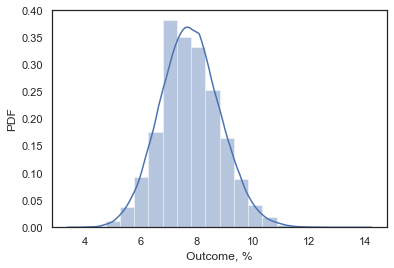

In [5]:
fig, ax = plt.subplots()
ax.set_ylabel('PDF')
ax.set_xlabel('Outcome, %')
_ = sns.distplot(bs_outcome_reps*100, bins=20, ax=ax)

print('95% confidence interval for Outcome, %' )
print(np.percentile(bs_outcome_reps*100, [2.5, 97.5]))

### Small multiples plot for Outcome share

In [6]:
# Select columns to plot
columns = list(df.columns[1:])
columns.remove('Сумма баллов')

# Specify cnum = number of columns in a plot
cnum = 6
# Calculate number of rows in a grid
rnum = round(len(columns)/cnum)+1

In [7]:
def plot_cname_outcome_share(cname, ax):
    """plot_cname_outcome(cname, ax) generates plot for `cname` column on `ax` axes"""
    data = df.groupby([cname]).agg(outcome_share=('ИСХОД','mean'), 
                                  outcome_sum=('ИСХОД','sum'), 
                                  count=('ИСХОД','size')).reset_index()
    data['outcome_share'] = data.outcome_share.round(2)
    
    sh = round(df['ИСХОД'].mean(), 2)
    
    ax.plot([-0.5, 1.5], [sh,sh], linestyle='--', alpha=0.3)
    
    ax.plot(data[cname],data['outcome_share'], alpha=0.8)
    ax.scatter(data[cname],data['outcome_share'], alpha=0.3, s=data['count']/2)
    for i in range(data.shape[0]):
        ax.annotate(data.loc[i, 'outcome_share'],
                   (data.loc[i, cname], data.loc[i, 'outcome_share']),
                   alpha=0.6)
    ax.set_title(cname)
    ax.margins(0.15)
    

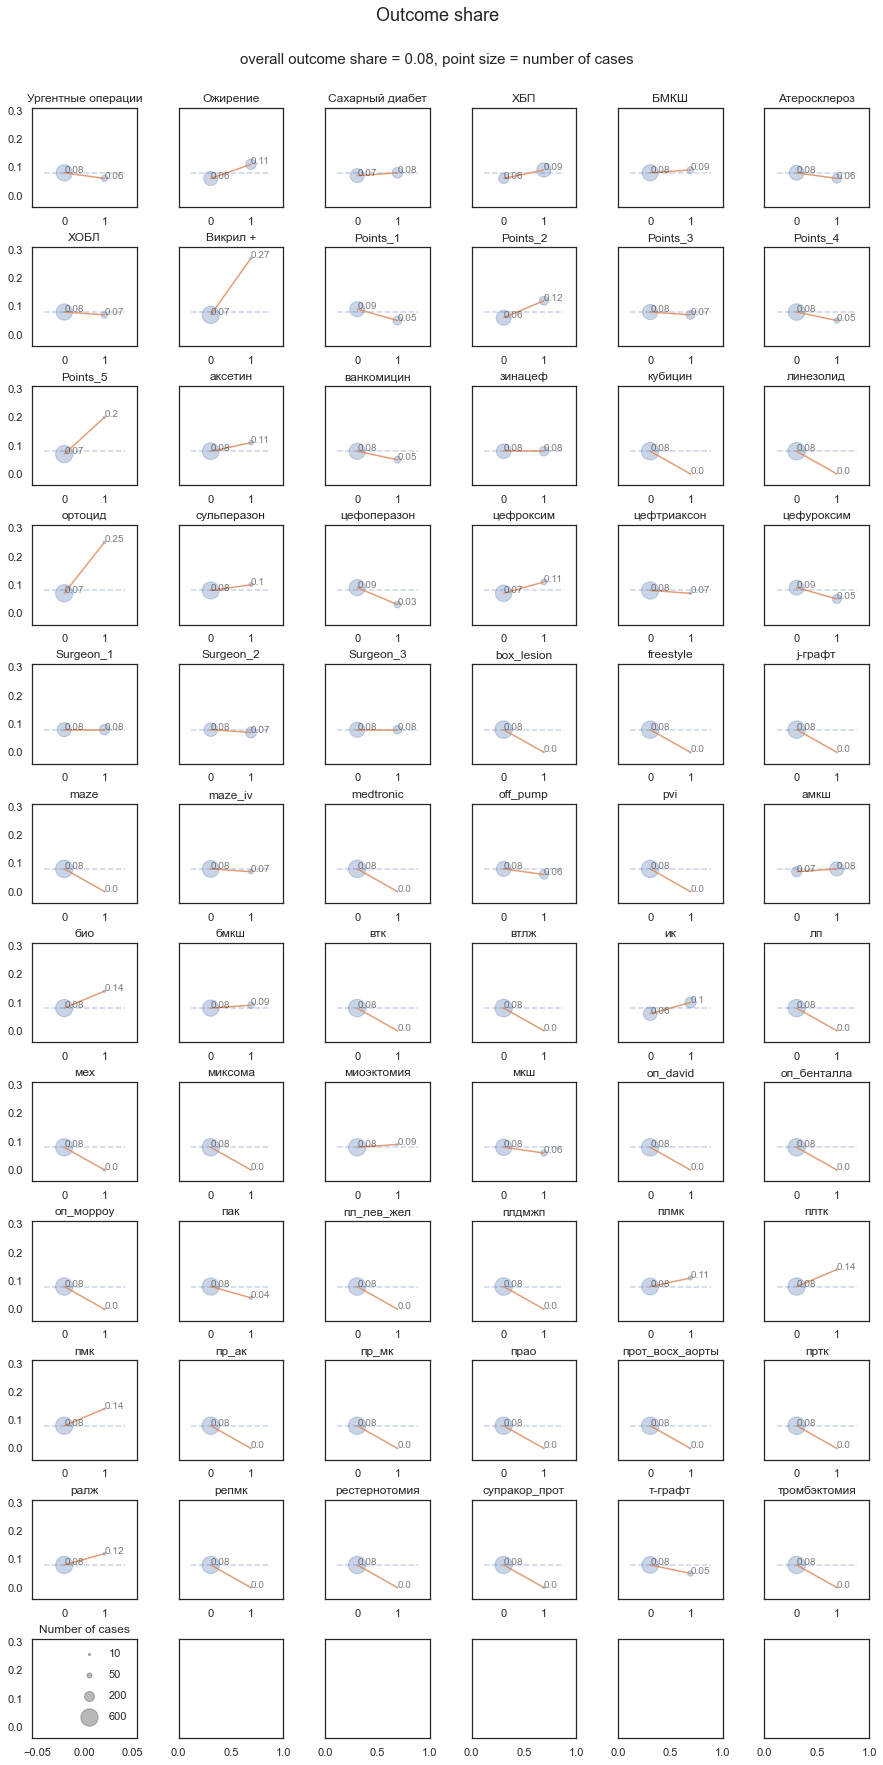

In [8]:
# Create subplots
fig, ax = plt.subplots(rnum, cnum, sharey=True, figsize=(15, 30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for rn in range(rnum):
        for cn in range(cnum):
            idx = rn*(cnum) + cn
            if (idx < len(columns)):
                plot_cname_outcome_share(cname=columns[idx], ax=ax[rn, cn]) 
            else:
                # Draw number of cases legend
                for s in [10, 50, 200, 600]:
                     ax[rn, cn].scatter([], [], alpha=0.3, s=s/2, label=str(s), c='k')
                ax[rn, cn].set_title('Number of cases')        
                ax[rn, cn].legend(scatterpoints=1, frameon=False, labelspacing=1)
                break
        
plt.text(x=0.5, y=0.92, s="Outcome share", fontsize=18, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.90, s= 'overall outcome share = {}, point size = number of cases'.format(round(df['ИСХОД'].mean(), 2)), 
         fontsize=15, ha="center", transform=fig.transFigure)

plt.show()

### Hypothesis testing

In [9]:
def frac_in_group(gr1, gr2):
    '''Calculates fraction of 1's in the first group'''
    frac = sum(gr1)/len(gr1)
    return frac

#### `Ожирение`

In [10]:
print('Outcomes by `Ожирение`')
print(df.groupby('Ожирение')['ИСХОД'].agg(['sum', 'size']))

Outcomes by `Ожирение`
          sum  size
Ожирение           
0          25   399
1          23   219


219 patients have `Ожирение` = 1, 23 оf them have `ИСХОД` = 1

*Does having `Ожирение` = 1 (overweight) make a difference for a patient in the value of `ИСХОД`?*
Let's evaluate the hypothesis that having `Ожирение` = 1 *does not* make any difference in the value of `ИСХОД`. We will use fraction of patients having overweight and `ИСХОД` = 1 as a test statistic and evaluate the probability of observing a fraction of patients having overweight and `ИСХОД` = 1 at least as large as the observed fraction 23/219. To do this we will permute overweight labels and then arbitrary divide them into those having overweight and having no overweight and compute fraction of patients having overweight and `ИСХОД` = 1.

In [11]:
23/219

0.1050228310502283

In [12]:
# Set seed
np.random.seed(42)

# Construct arrays of data
overweight_true = np.array([True]*23 + [False]*(219 - 23))
overweight_false = np.array([True]*25 + [False]*(399 - 25))

# draw 100000 permutation replicates of test statistic
permutation_replicates = draw_perm_reps(overweight_true, overweight_false, frac_in_group, 100000)
# compute and print p value
p = np.sum(permutation_replicates >= 23/219) / len(permutation_replicates)
print('p-value = ', p)

p-value =  0.04255


There is a 4 percent probability to see the observed fraction of patients having overweight and ИСХОД = 1 or more, assuming the null hypothesis is true and we can **reject** the null hypothesis

#### `цефуроксим`

In [13]:
print('Outcomes by `цефуроксим`')
print(df.groupby('цефуроксим')['ИСХОД'].agg(['sum', 'size']))

Outcomes by `цефуроксим`
            sum  size
цефуроксим           
0            39   452
1             9   166


In [14]:
9/166

0.05421686746987952

166 patients have `цефуроксим` = 1, 9 оf them have `ИСХОД` = 1

*Does having `цефуроксим` = 1 make a difference for a patient in the value of `ИСХОД`?*
Let's evaluate the hypothesis that having `цефуроксим` = 1 *does not* make any difference in the value of `ИСХОД`. We will use fraction of patients being treated with cefuroxime  and `ИСХОД` = 1 as a test statistic and evaluate the probability of observing a fraction of patients being treated with cefuroxime and `ИСХОД` = 1 at least as small as the observed fraction 9/166. To do this we will permute cefuroxime labels and then arbitrary divide them into cases being treated with cefuroxime and cases not being treated with cefuroxime and compute fraction of patients being treated with cefuroxime and `ИСХОД` = 1.

In [15]:
# Set seed
np.random.seed(42)

# Construct arrays of data
cef = np.array([True]*9 + [False]*(166 - 9))
nocef = np.array([True]*39 + [False]*(452 - 39))

# draw 100000 permutation replicates of test statistic
permutation_replicates = draw_perm_reps(cef, nocef, frac_in_group, 100000)
# compute and print p value
p = np.sum(permutation_replicates <= 9/166) / len(permutation_replicates)
print('p-value = ', p)

p-value =  0.12313


There is a **12 percent probability** to see the observed fraction of patients being treated with cefuroxime having ИСХОД = 1 or less, assuming the null hypothesis is true and we **can not reject** the null hypothesis

#### `ванкомицин` + `цефоперазон`

In [16]:
df['v_or_c'] = ((df['ванкомицин'] + df['цефоперазон']) > 0).astype('int')

In [17]:
print('Outcomes by `v_or_c`')
print(df.groupby('v_or_c')['ИСХОД'].agg(['sum', 'size']))

Outcomes by `v_or_c`
        sum  size
v_or_c           
0        42   496
1         6   122


In [18]:
6/122

0.04918032786885246

122 patients have `ванкомицин` = 1 or `цефоперон` = 1, 6 оf them have `ИСХОД` = 1

*Does having `ванкомицин` = 1 or `цефоперон` = 1 make a difference for a patient in the value of `ИСХОД`?*
Let's evaluate the hypothesis that having `ванкомицин` = 1 or `цефоперон` = 1 *does not* make any difference in the value of `ИСХОД`. We will use fraction of patients being treated with this combination of medicines and having `ИСХОД` = 1 as a test statistic and evaluate the probability of observing a fraction of patients being treated and having `ИСХОД` = 1 at least as small as the observed fraction 6/122. To do this we will permute treatment labels and then arbitrary divide them into cases being treated and cases not being treated and compute fraction of patients being treated and having `ИСХОД` = 1.

In [19]:
# Set seed
np.random.seed(42)

# Construct arrays of data
v_c = np.array([True]*6 + [False]*(122 - 6))
nov_c = np.array([True]*42 + [False]*(496 - 42))

# draw 100000 permutation replicates of test statistic
permutation_replicates = draw_perm_reps(v_c, nov_c, frac_in_group, 100000)
# compute and print p value
p = np.sum(permutation_replicates <= 6/122) / len(permutation_replicates)
print('p-value = ', p)

p-value =  0.12608


There is a **12.6 percent probability** to see the observed value of test statistc or less, assuming the null hypothesis is true and we **can not reject** the null hypothesis

#### `ик` (on-pump)

In [20]:
print('Outcomes by `ик`')
print(df.groupby('ик')['ИСХОД'].agg(['sum', 'size']))

Outcomes by `ик`
    sum  size
ик           
0    24   374
1    24   244


In [21]:
24/244

0.09836065573770492

224 surgeries where performed "on-pump", 24 оf them have `ИСХОД` = 1

*Does having `ик` = 1 (on-pump) make a difference for a patient in the value of `ИСХОД`?*
Let's evaluate the hypothesis that having `ик` = 1 *does not* make any difference in the value of `ИСХОД`. We will use fraction of surgeries being performed "on-pump" having `ИСХОД` = 1 as a test statistic and evaluate the probability of observing a fraction of patients having `ик` = 1 (on-pump) having `ИСХОД` = 1 at least as large as the observed fraction 24/244. To do this we will permute treatment labels and then arbitrary divide them into "on-pump" cases and "off-pump" cases and compute fraction of patients having `ик` = 1 (on-pump) and having `ИСХОД` = 1.

In [22]:
# Set seed
np.random.seed(42)

# Construct arrays of data
pump = np.array([True]*24 + [False]*(374 - 24))
off_pump = np.array([True]*24 + [False]*(244 - 24))

# draw 100000 permutation replicates of test statistic
permutation_replicates = draw_perm_reps(pump, off_pump, frac_in_group, 100000)
# compute and print p value
p = np.sum(permutation_replicates >= 24/244) / len(permutation_replicates)
print('p-value = ', p)

p-value =  0.00898


There is less then 1 percent probability to see the observed fraction of patients having `ик` = 1 and `ИСХОД` = 1 or more, assuming the null hypothesis is true and we can **reject** the null hypothesis

### CABG Surgery type (АМКШ)

In [266]:
cabg = df.loc[df['амкш'] == 1, ['ик', 'off_pump']]

In [267]:
cabg['ик | off_pump'] = cabg['ик']*2 + cabg['off_pump']
cabg['ик | off_pump'] = cabg['ик | off_pump'].astype('category')
cabg['ик | off_pump'] = cabg['ик | off_pump'].cat.rename_categories({0: 'error: ик=0, off_pump=0', 
                                                                     1: 'off_pump=1', 
                                                                     2: 'ик=1', 
                                                                     3: 'error: ик=1 & off_pump=1'})

cabg['ик'] = cabg['ик'] + np.random.uniform(low = 0, high = 0.9, size = cabg.shape[0])
cabg['off_pump'] = cabg['off_pump'] + np.random.uniform(low = 0, high = 0.9, size = cabg.shape[0])

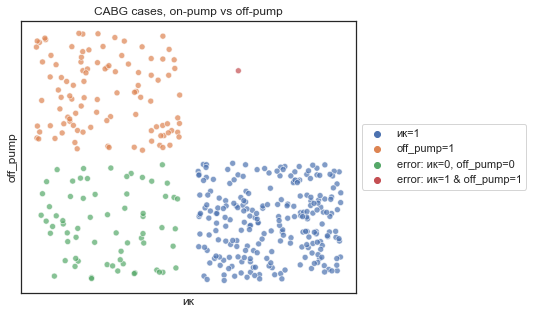

In [268]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(x = 'ик', y = 'off_pump', data = cabg, alpha = 0.7, hue = 'ик | off_pump', legend = 'brief', ax=ax)
_ = ax.set_title('CABG cases, on-pump vs off-pump')
_ = ax.xaxis.set_ticks([])
_ = ax.yaxis.set_ticks([])

# Remove hue label from the legend and place it outside of the plot
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles=handles[1:], labels=labels[1:], loc='center left', bbox_to_anchor=(1, 0.5))

In [260]:
cabg['ик | off_pump'].value_counts()

ик=1                        236
off_pump=1                  103
error: ик=0, off_pump=0      66
error: ик=1 & off_pump=1      1
Name: ик | off_pump, dtype: int64